# [Deep Learning](https://github.com/M-Sc-AUT/M.Sc-Computer-Architecture/tree/main/Deep%20Learning) - Spring 2024
#### [Reza Adinepour](https://github.com/rezaAdinepour)
#### Stu.ID: 402131055

## Question 1 - Part 3:

In this part, we will apply some of NLP techniques on a dataset containing Wikipedia texts ($\texttt{WikipediaEvents.csv}$ file). The primary goal of this part is to demonstrate how various NLP techniques can be effectively utilized in data science to process and analyze textual data.

## Project Objectives

1. **Text Preprocessing:** Cleaning the text in the dataset for analysis, which includes converting text to lower case, removing punctuation, and eliminating numerical expressions.

2. **Stopwords Removal:** Enhancing feature extraction by omitting commonly occurring words that add little value to the text's meaning.

3. **Word Frequency Analysis:** Identifying the most prevalent terms by calculating word frequencies within the text.

4. **Data Visualization:** Using graphical tools like barplot graphs and WordCloud for a more illustrative presentation of the data.

### Install important libraries

In [4]:
!pip install nltk
!pip install twython
!pip install textblob
!pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


### Import libraries

In [6]:
from warnings import filterwarnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nltk
from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from textblob import Word, TextBlob
from wordcloud import WordCloud

### Adjusting row column settings

In [10]:
filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

### Loading dataset

In [11]:
df = pd.read_csv("WikipediaEvents.csv", index_col=0)
print("shape of dataset: {}" .format(df.shape))
df.head()

shape of dataset: (473, 1)


,text
0,"January 1, 2022 – The Regional Comprehensive E..."
1,"January 2, 2022 – Abdalla Hamdok resigns as Pr..."
2,"January 4, 2022 – The five permanent members o..."
3,"January 5, 2022 – A nationwide state of emerge..."
4,"January 6, 2022 – The CSTO deploys a ""peacekee..."


## Text preprocessing

In [13]:
df["text"]

0      January 1, 2022 – The Regional Comprehensive E...
1      January 2, 2022 – Abdalla Hamdok resigns as Pr...
2      January 4, 2022 – The five permanent members o...
3      January 5, 2022 – A nationwide state of emerge...
4      January 6, 2022 – The CSTO deploys a "peacekee...
                             ...                        
468    October, 2024 – 2024 Georgian presidential ele...
469     November, 2024 – 2024 Namibian general election.
470    November, 2024 – 2024 Romanian presidential el...
471    November, 2024 – Lee Hsien Loong, Prime Minist...
472    December, 2024 – 2024 Croatian presidential el...
Name: text, Length: 473, dtype: object

### 1. Lowercases, Punctuation, Numbers and Newline Characters

In [14]:
def clean_text(text):
    """
    Clean and preprocess text data.

    This function performs several cleaning operations on text data:
    - Lowercases the text (Case Folding)
    - Removes punctuation
    - Removes numbers
    - Removes newline characters

    Parameters:
    text (pandas.Series): A pandas Series containing text data.

    Returns:
    pandas.Series: A pandas Series with cleaned text.
    """
    # Lowercasing (Case Folding)
    text = text.str.lower()
    # Removing punctuations, numbers, and newline characters
    text = text.str.replace(r'[^\w\s]', '', regex=True)
    text = text.str.replace("\n", '', regex=True)
    text = text.str.replace('\d', '', regex=True)
    return text

In [15]:
df["text"] = clean_text(df["text"])
df["text"]

0      january    the regional comprehensive economic...
1      january    abdalla hamdok resigns as prime min...
2      january    the five permanent members of the u...
3      january    a nationwide state of emergency is ...
4      january    the csto deploys a peacekeeping mis...
                             ...                        
468            october    georgian presidential election
469                november    namibian general election
470           november    romanian presidential election
471    november   lee hsien loong prime minister of s...
472           december    croatian presidential election
Name: text, Length: 473, dtype: object

### 2. Stopwords Removal

In [16]:
nltk.download("stopwords")
stop_words = stopwords.words("english")

[nltk_data] Downloading package stopwords to /home/reza/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
def remove_stopwords(text):
    """
    Remove stopwords from text data.

    This function filters out common stopwords from the text data. 
    Stopwords are removed based on the NLTK's English stopwords list.

    Parameters:
    text (pandas.Series): A pandas Series containing text data.

    Returns:
    pandas.Series: A pandas Series with stopwords removed from the text.
    """
    # Removing stopwords
    text = text.apply(lambda x: " ".join(word for word in str(x).split() if word not in stop_words))
    return text

In [19]:
df["text"] = remove_stopwords(df["text"])
df["text"]

0      january regional comprehensive economic partne...
1      january abdalla hamdok resigns prime minister ...
2      january five permanent members un security cou...
3      january nationwide state emergency declared ka...
4      january csto deploys peacekeeping mission kaza...
                             ...                        
468               october georgian presidential election
469                   november namibian general election
470              november romanian presidential election
471    november lee hsien loong prime minister singap...
472              december croatian presidential election
Name: text, Length: 473, dtype: object

### 3. Rare Words and Frequent Words

In [20]:
def remove_rare_words(df, column_name, n_rare_words=1000):
    """
    Remove rare words from a specified column in a pandas DataFrame.

    This function identifies and removes the least frequently occurring words
    in the text data. It is useful for removing rare words that might not contribute
    significantly to the analysis or modeling.

    Parameters:
    df (pandas.DataFrame): A pandas DataFrame containing the text data.
    column_name (str): The name of the column in the DataFrame to clean.
    n_rare_words (int): The number of least frequent words to remove.

    Returns:
    pandas.DataFrame: A DataFrame with rare words removed from the specified column.
    """
    # Identifying the rare words
    freq = pd.Series(' '.join(df[column_name]).split()).value_counts()
    rare_words = freq[-n_rare_words:]

    # Removing the rare words
    df[column_name] = df[column_name].apply(lambda x: " ".join(word for word in x.split() if word not in rare_words))
    return df

In [21]:
df = remove_rare_words(df, 'text', 1000)
df["text"]

0      january regional comprehensive economic larges...
1      january resigns prime minister sudan amid dead...
2      january five permanent members un security fra...
3      january nationwide state emergency declared ka...
4      january deploys peacekeeping mission kazakhsta...
                             ...                        
468               october georgian presidential election
469                   november namibian general election
470              november romanian presidential election
471    november lee hsien loong prime minister singap...
472              december croatian presidential election
Name: text, Length: 473, dtype: object

### 4. Tokenization

In [82]:
nltk.download('punkt')
df["text"].apply(lambda x: TextBlob(x).words)

[nltk_data] Downloading package punkt to /home/reza/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


0      [january, regional, comprehensive, economic, l...
1      [january, resigns, prime, minister, sudan, ami...
2      [january, five, permanent, member, un, securit...
3      [january, nationwide, state, emergency, declar...
4      [january, deploys, peacekeeping, mission, kaza...
                             ...                        
468          [october, georgian, presidential, election]
469              [november, namibian, general, election]
470         [november, romanian, presidential, election]
471    [november, lee, hsien, loong, prime, minister,...
472         [december, croatian, presidential, election]
Name: text, Length: 473, dtype: object

### 5. Lemmatization

In [23]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /home/reza/nltk_data...
[nltk_data] Downloading package omw-1.4 to /home/reza/nltk_data...


True

In [30]:
def apply_lemmatization(df, column_name):
    """
    Apply lemmatization to a specified column in a pandas DataFrame.

    This function performs lemmatization on the text data in the specified column.
    Lemmatization involves reducing each word to its base or root form.

    Parameters:
    df (pandas.DataFrame): A pandas DataFrame containing the text data.
    column_name (str): The name of the column in the DataFrame to process.

    Returns:
    pandas.DataFrame: A DataFrame with lemmatized text in the specified column.
    """
    # Applying lemmatization
    df[column_name] = df[column_name].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

    return df

In [31]:
df = apply_lemmatization(df, 'text')
df['text']

0      january regional comprehensive economic larges...
1      january resigns prime minister sudan amid dead...
2      january five permanent member un security fran...
3      january nationwide state emergency declared ka...
4      january deploys peacekeeping mission kazakhsta...
                             ...                        
468               october georgian presidential election
469                   november namibian general election
470              november romanian presidential election
471    november lee hsien loong prime minister singap...
472              december croatian presidential election
Name: text, Length: 473, dtype: object

### 6. Calculation of Term Frequencies & Barplot & Word Cloud

In [72]:
def plot_tf_and_wordcloud(df, column_name, tf_threshold=2000, max_font_size=50, max_words=100, background_color="black"):
    """
    Calculate term frequency (TF) and generate a word cloud for a specified column in a pandas DataFrame.

    This function performs two main tasks:
    1. Term Frequency Calculation and Bar Chart: Calculates the frequency of each word in the specified column and plots a bar chart for words with a frequency above a certain threshold.
    2. Word Cloud Generation: Generates and displays a word cloud based on the text in the specified column.

    Parameters:
    df (pandas.DataFrame): A pandas DataFrame containing the text data.
    column_name (str): The name of the column to analyze.
    tf_threshold (int): The threshold for term frequency to be included in the bar chart.
    max_font_size (int): Maximum font size for the word cloud.
    max_words (int): The maximum number of words for the word cloud.
    background_color (str): Background color for the word cloud.

    Returns:
    None: This function only plots the results and does not return any value.
    """
    # 1. Term Frequency Calculation and Bar Chart
    tf = df[column_name].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
    tf.columns = ["words", "tf"]
    high_tf = tf[tf["tf"] > tf_threshold]
    high_tf.plot.bar(x="words", y="tf", title="Term Frequency Bar Chart")
    plt.show()

    # 2. Word Cloud Generation
    text = " ".join(i for i in df[column_name])
    wordcloud = WordCloud(max_font_size=max_font_size, max_words=max_words, background_color=background_color).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title("Word Cloud")
    plt.axis("off")
    plt.show()

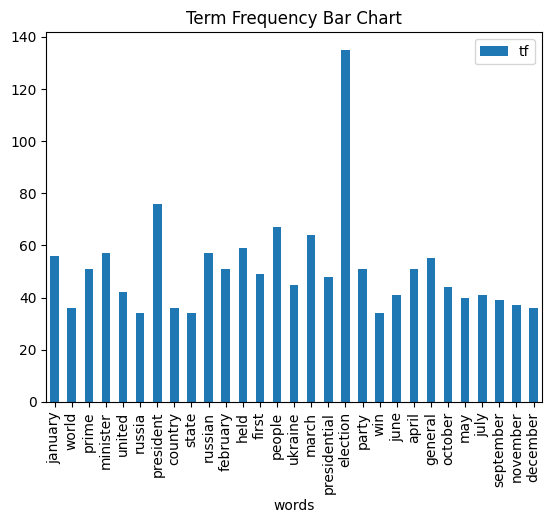

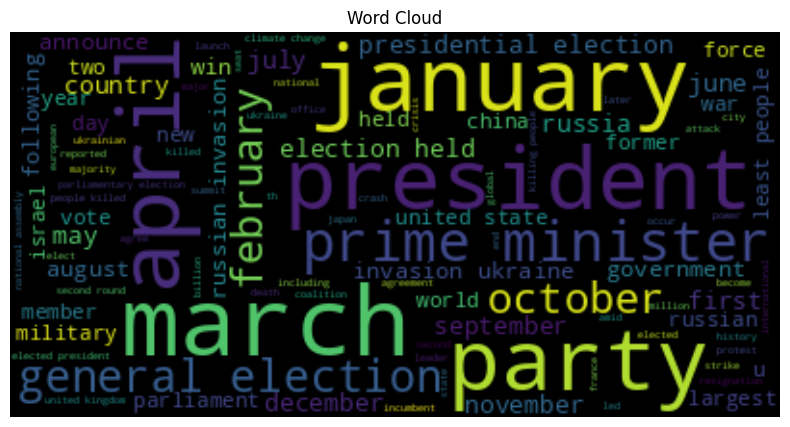

In [78]:
plot_tf_and_wordcloud(df, "text", tf_threshold=30)

In [71]:
df['text']

0      january regional comprehensive economic larges...
1      january resigns prime minister sudan amid dead...
2      january five permanent member un security fran...
3      january nationwide state emergency declared ka...
4      january deploys peacekeeping mission kazakhsta...
                             ...                        
468               october georgian presidential election
469                   november namibian general election
470              november romanian presidential election
471    november lee hsien loong prime minister singap...
472              december croatian presidential election
Name: text, Length: 473, dtype: object